## Installing required libraries



In [141]:
!pip install kaggle
!pip install imblearn
!pip install scikit-learn
!pip install seaborn
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, RocCurveDisplay

## Fetching data from Kaggle

The dataset is a Kaggle dataset called [_Audio features and lyrics of Spotify songs_](https://www.kaggle.com/datasets/imuhammad/audio-features-and-lyrics-of-spotify-songs).

This dataset contains various types of information of over more that 18000 Spotify songs including, artist, album, audio features (e.g. loudness), lyrics, the language of lyrics, genres and sub-genres.

The original dataset was used in the [third week of the TidyTeusday project](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-01-21) and only contained audio features and genres. The lyrics were added to the dataset using the [`genius`](https://cran.r-project.org/web/packages/genius/index.html) library in R, and the language of the lyrics were included using the [`langdetect`](https://pypi.org/project/langdetect/) library in python. However, only around half of the original songs are available in this dataset as lyrics could not be retreived for many songs.

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"slothonmeth","key":"cd262fc091f9601cd35187e083b17459"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d imuhammad/audio-features-and-lyrics-of-spotify-songs
! unzip audio-features-and-lyrics-of-spotify-songs.zip -d data

 41% 5.00M/12.3M [00:00<00:00, 22.1MB/s]
100% 12.3M/12.3M [00:00<00:00, 48.8MB/s]
Archive:  audio-features-and-lyrics-of-spotify-songs.zip
  inflating: data/spotify_songs.csv  


## Getting to know the Dataset

In [131]:
data = pd.read_csv('data/spotify_songs.csv')

### Dataset statistics

The dataset has 18454 unique tracks from 6031 unique artists

In [71]:
data.describe(include='all')[:2]

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
count,18454,18454,18454,18194,18454.0,18454,18454,18454,18454,18454,...,18454.0,18454.0,18454.0,18454.0,18454.0,18454.0,18454.0,18454.0,18454.0,18194
unique,18454,15198,6031,15977,NaN,14278,12671,3817,442,464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34


In [ ]:
data.head()

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,1srJQ0njEQgd8w4XSqI4JQ,Trip,2001-01-01,Pinoy Classic Rock,37i9dQZF1DWYDQ8wBxd7xt,...,-10.068,1,0.0236,0.27900,0.01170,0.0887,0.566,97.091,235440,tl
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,...,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,...,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,...,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,...,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en


In [ ]:
data.dtypes

track_id                     object
track_name                   object
track_artist                 object
lyrics                       object
track_popularity              int64
track_album_id               object
track_album_name             object
track_album_release_date     object
playlist_name                object
playlist_id                  object
playlist_genre               object
playlist_subgenre            object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                   int64
language                     object
dtype: object

### Track languages

The dataset has predominantly english songs - around ~84% of total songs



In [ ]:
data['language'].value_counts()

en    15405
es     1705
de      241
pt      176
it      133
pl       76
nl       72
fr       65
tl       63
da       40
id       34
ko       29
vi       24
so       16
sw       16
ro       16
cy       12
no       10
hi       10
ja        8
et        7
tr        5
sv        5
af        5
ru        4
sq        3
hr        3
ar        2
cs        2
ca        2
el        2
hu        1
fi        1
sk        1
Name: language, dtype: int64

### Track genres

In the dataset, the genre of a music track is determined to be the genre of the playlist it is a part of.

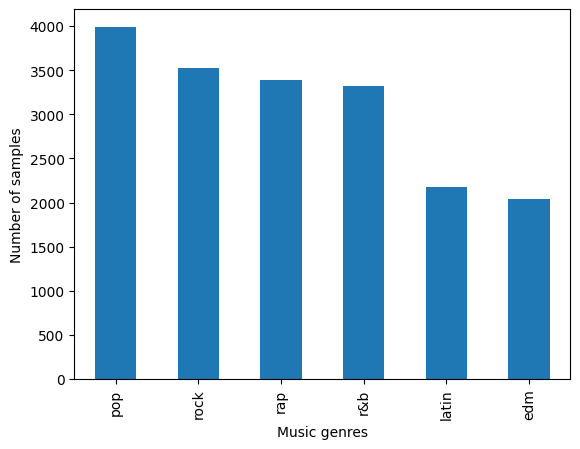

In [ ]:
count = data['playlist_genre'].value_counts()
count.plot.bar()
plt.ylabel('Number of samples')
plt.xlabel('Music genres')
plt.show()

## Preprocessing

### Drop non-english songs
There are no good word embeddings available for non-english songs; in addition, only ~16% of total data samples are non-english

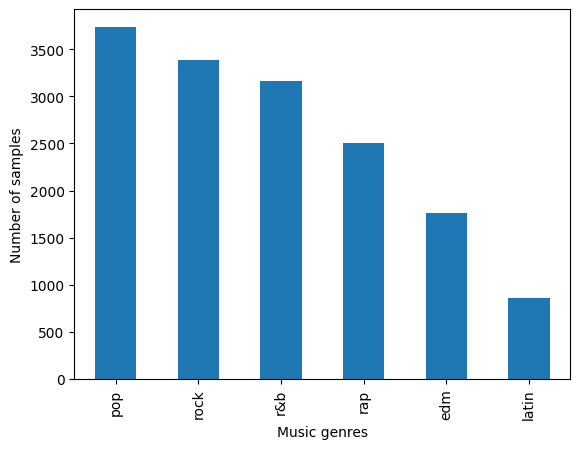

In [132]:
data = data.loc[data['language'] == 'en']

count = data['playlist_genre'].value_counts()
count.plot.bar()
plt.ylabel('Number of samples')
plt.xlabel('Music genres')
plt.show()

### Remove `latin` songs
We do not have enough samples for `latin`

In [133]:
data = data.loc[data['playlist_genre'] != 'latin']
data['playlist_genre'].value_counts()

pop     3739
rock    3388
r&b     3161
rap     2502
edm     1758
Name: playlist_genre, dtype: int64

### Remove outliers

We are going to remove outliers based on song duration

Number of outliers: 294



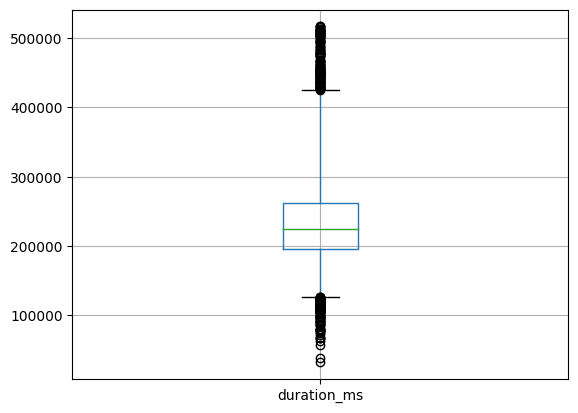

In [134]:
plt.figure()
B = data[['duration_ms']].boxplot(whis=[1, 99], return_type='dict')
lower, upper = [item.get_ydata()[1] for item in B['whiskers']]

orig = len(data)
data = data[data['duration_ms'] > lower]
data = data[data['duration_ms'] < upper]
new = len(data)
print(f'Number of outliers: {orig - new}\n')

### Drop unusable features

Features like `track_id`, `track_artist`, `track_album_id`, `playlist_id` are not realistically expected to provide any information regarding a music track's genre

In [135]:
data.drop(
    ['track_id', 'track_name', 'track_artist', 'track_popularity', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id', 'playlist_subgenre', 'duration_ms', 'language'],
    axis=1,
    inplace=True
)
data.dtypes

lyrics               object
playlist_genre       object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object

Now we can split our dataset into `X` (input) and `y` (target labels) - here, our target labels are the values in the column `playlist_genre`

In [136]:
X = data.loc[:, data.columns != 'playlist_genre']
y = data['playlist_genre']

### Balance the dataset

We will be balancing the data such that we will have 3K samples for each genre by doing random undersampling and oversampling

In [137]:
n_samples = 3000

def sampling_strategy(labels, n_samples, sampling_type):
    target_labels = ''
    if sampling_type == 'undersampling':
        target_labels = labels.value_counts() > n_samples
    elif sampling_type == 'oversampling':
        target_labels = labels.value_counts() < n_samples
    tl = target_labels[target_labels == True].index
    sampling_strategy = {}
    for target in tl:
        sampling_strategy[target] = n_samples
    return sampling_strategy

#### Undersampling majority classes

In [138]:
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy(y, n_samples, 'undersampling'))
X_under, y_under = under_sampler.fit_resample(X, y)

#### Oversampling minority classes

In [139]:
over_sampler = RandomOverSampler(sampling_strategy=sampling_strategy(y_under, n_samples, 'oversampling'))
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

The new dataset now has 3000 samples for each genre

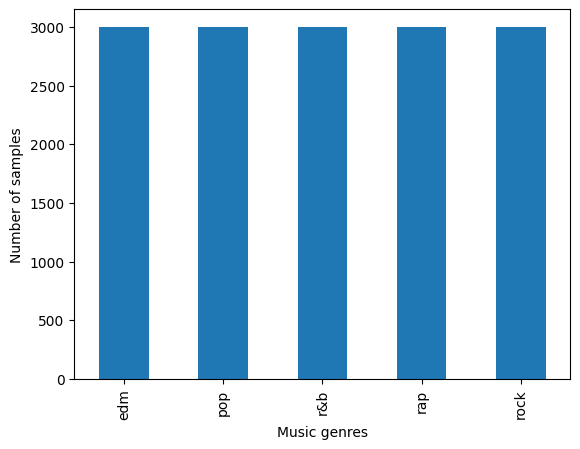

In [140]:
count = y_bal.value_counts()
count.plot.bar()
plt.ylabel('Number of samples')
plt.xlabel('Music genres')
plt.show()

### Convert Lyrics into Word Embeddings

In [152]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### Creating custom document embeddings

We will be using Doc2Vec to express the song lyrics as document embeddings

In [153]:
lyric_data = X_bal['lyrics']
train_corpus = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in list(enumerate(lyric_data))]
model = Doc2Vec(vector_size=50, min_count=1, epochs=10, dm=0)
model.build_vocab(train_corpus)
# train model
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

Save the model for future use

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [157]:
model.save('drive/MyDrive/Colab Notebooks/Muse/lyric_word_embeddings')

Load the model

In [158]:
model = Doc2Vec.load('drive/MyDrive/Colab Notebooks/Muse/lyric_word_embeddings')

Use the word embedding model to create required lyric embeddings

In [165]:
X_lyric_emd = pd.DataFrame([model.dv[f'{i}'] for i in range(len(X_bal))])

We now have our final dataset with audio features and lyric embeddings

In [166]:
y = y_bal

X = X_bal.copy()
for c in X_lyric_emd.columns:
    X[c] = X_lyric_emd[c]
X.head()

,lyrics,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,40,41,42,43,44,45,46,47,48,49
0,"Don't run away, it's getting colder Our hearts...",0.573,0.746,10,-4.894,1,0.0421,0.02490,0.000000,0.3610,...,0.177553,0.093146,-0.123022,-0.809430,0.159325,-0.453519,-0.590012,-0.698192,0.173562,0.939875
1,I love when you pulling up in your jeep Pumpin...,0.627,0.832,6,-5.525,0,0.0478,0.00939,0.003050,0.1150,...,0.696765,0.666129,-0.303155,-0.437975,0.000838,-0.013675,-0.231198,-0.730650,-0.217618,-0.158650
2,Somebody said you got a new friend But does sh...,0.608,0.648,1,-5.569,1,0.0360,0.01940,0.001040,0.0897,...,0.114621,-0.081609,-0.459386,-0.091970,-0.453114,1.204160,-0.297703,-0.365118,1.166662,0.233175
3,I always say sorry But that word don't mean no...,0.531,0.630,2,-5.677,1,0.0433,0.21600,0.000000,0.0540,...,0.002960,-0.088389,0.358142,-0.420322,0.171302,-0.669675,0.417264,-0.171808,0.887295,0.594988
4,When she's ok Then I'm alright When she's awak...,0.656,0.752,4,-5.622,1,0.0378,0.35400,0.000011,0.0707,...,-0.724699,-0.102035,-0.021300,-0.673826,-0.746891,0.132160,0.296754,-0.684891,0.255443,0.412745


### Split dataset into train-test-validation

We will be dividing the dataset into a 80-10-10 train-test-validation splits

In [68]:
def train_test_validation_split(x_data, y_data):
    # training split is 70% of total data
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=1)
    # divide remaining 30% in half for test and validation splits
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

    return X_train, y_train, X_test, y_test, X_val, y_val

In [167]:
X_train, y_train, X_test, y_test, X_val, y_val = train_test_validation_split(X, y)

## Training the models

We will have two sets of models:
- the first set of models to classify based on lyric word embeddings
- the second set of models to classify based on audio features

The models are split up in this form because the assumption is that models "learn" differently when given lyrics as input as compared to audio features

After training the sets of models, we will have them predict on the validation split, and note their validation accuracies.

We will finally create an ensemble from both sets of models, where predictions from each model is weighted by their validation accuracies (a measure of how much confidence we have in a model's prediction) - the predicted label with the highest weight will be the final label.

In [224]:
def train_models_and_weights(X_train, y_train, X_valid, y_valid, model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    print(f'Validation accuracy for {model_name}: {acc}')
    return model, acc

In [225]:
lyric_models = []
lyric_model_weights = []

audio_models = []
audio_model_weights = []

### Models trained on lyric document embeddings

#### One vs Rest SVC

In [226]:
ovr_svc, acc = train_models_and_weights(
    X_train.iloc[:, 12:], y_train, X_val.iloc[:, 12:], y_val, OneVsRestClassifier(SVC()), 'OneVsRest (SVC)'
)
lyric_models.append(ovr_svc)
lyric_model_weights.append(acc)

Validation accuracy for OneVsRest (SVC): 0.6097777777777778


#### One vs Rest Random Forest Classifier

In [227]:
rf, acc = train_models_and_weights(
    X_train.iloc[:, 12:], y_train, X_val.iloc[:, 12:], y_val, OneVsRestClassifier(RandomForestClassifier()), 'One vs Rest (Random Forest)'
)
lyric_models.append(rf)
lyric_model_weights.append(acc)

Validation accuracy for One vs Rest (Random Forest): 0.6208888888888889


#### One vs Rest Extra Trees Classifier

In [228]:
ovr_et, acc = train_models_and_weights(
    X_train.iloc[:, 12:], y_train, X_val.iloc[:, 12:], y_val, OneVsRestClassifier(ExtraTreesClassifier()), 'OneVsRest (Extra Trees)'
)
lyric_models.append(ovr_et)
lyric_model_weights.append(acc)

Validation accuracy for OneVsRest (Extra Trees): 0.6288888888888889


### Models trained on audio features

#### One vs Rest Random Forest Classifier

In [249]:
ovr_rf, acc = train_models_and_weights(
    X_train.iloc[:, 1:12], y_train, X_val.iloc[:, 1:12], y_val, OneVsRestClassifier(RandomForestClassifier()), 'One vs Rest (Random Forest)'
)
audio_models.append(ovr_rf)
audio_model_weights.append(acc)

Validation accuracy for One vs Rest (Random Forest): 0.6648888888888889


#### One vs Rest Extra Trees Classifier

In [250]:
ovr_et, acc = train_models_and_weights(
    X_train.iloc[:, 1:12], y_train, X_val.iloc[:, 1:12], y_val, OneVsRestClassifier(ExtraTreesClassifier()), 'One vs Rest (Extra Trees)'
)
audio_models.append(ovr_et)
audio_model_weights.append(acc)

Validation accuracy for One vs Rest (Extra Trees): 0.6568888888888889


#### One vs Rest Histogram-based Gradient Boosting Classifier

In [251]:
from sklearn.ensemble import HistGradientBoostingClassifier
ovr_hgb, acc = train_models_and_weights(
    X_train.iloc[:, 1:12], y_train, X_val.iloc[:, 1:12], y_val, OneVsRestClassifier(HistGradientBoostingClassifier()), 'One vs Rest (Random Forest)'
)
audio_models.append(ovr_hgb)
audio_model_weights.append(acc)

Validation accuracy for One vs Rest (Random Forest): 0.6457777777777778


## Testing the models

The plan is to conduct four experiments:
- Test on each model separately
- Test on an ensemble of lyric-trained model
- Test on an ensemble of audio-feature-trained model
- Test on the multi-modal model of all the models combined

### The ensemble model

The ensemble model's prediction will be a weighted majority vote of each separate model, where the weight of a model's prediction is it's validation accuracy

In [256]:
def get_ensemble_prediction(n_preds, y_preds, model_weights):
    final_pred = []
    for i in range(n_preds):
        weighted_labels = {'pop': 0, 'rock': 0, 'r&b': 0, 'rap': 0, 'edm': 0}
        preds = [y_pred[i] for y_pred in y_preds]
        for j, pred in enumerate(preds):
            weighted_labels[pred] += model_weights[j]
        final_pred.append(max(weighted_labels, key=weighted_labels.get))
    return final_pred

In [286]:
lyric_model_preds = []
audio_model_preds = []
n_preds = len(y_test)

### Testing on lyric-trained models

In [287]:
for model in lyric_models:
    y_pred = model.predict(X_test.iloc[:, 12:])
    lyric_model_preds.append(y_pred)
    print(f'{model}:\n')
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f'Accuracy\t\t: {report["accuracy"]}')
    print(f'Weighted Average F1\t: {report["weighted avg"]["f1-score"]}')
    print()
    print(classification_report(y_test, y_pred))

OneVsRestClassifier(estimator=SVC()):

Accuracy		: 0.6186666666666667
Weighted Average F1	: 0.6082024768703942

              precision    recall  f1-score   support

         edm       0.61      0.66      0.63       457
         pop       0.56      0.37      0.45       445
         r&b       0.56      0.50      0.53       442
         rap       0.74      0.87      0.80       449
        rock       0.58      0.70      0.63       457

    accuracy                           0.62      2250
   macro avg       0.61      0.62      0.61      2250
weighted avg       0.61      0.62      0.61      2250

OneVsRestClassifier(estimator=RandomForestClassifier()):

Accuracy		: 0.6173333333333333
Weighted Average F1	: 0.6097716555328708

              precision    recall  f1-score   support

         edm       0.70      0.68      0.69       457
         pop       0.49      0.37      0.42       445
         r&b       0.54      0.51      0.52       442
         rap       0.75      0.84      0.79       4

### Testing on audio-trained models

In [288]:
for model in audio_models:
    y_pred = model.predict(X_test.iloc[:, 1:12])
    audio_model_preds.append(y_pred)
    print(f'{model}:\n')
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f'Accuracy\t\t: {report["accuracy"]}')
    print(f'Weighted Average F1\t: {report["weighted avg"]["f1-score"]}')
    print()
    print(classification_report(y_test, y_pred))

OneVsRestClassifier(estimator=RandomForestClassifier()):

Accuracy		: 0.6426666666666667
Weighted Average F1	: 0.6320334997848345

              precision    recall  f1-score   support

         edm       0.76      0.81      0.78       457
         pop       0.46      0.32      0.38       445
         r&b       0.55      0.55      0.55       442
         rap       0.68      0.77      0.72       449
        rock       0.69      0.75      0.72       457

    accuracy                           0.64      2250
   macro avg       0.63      0.64      0.63      2250
weighted avg       0.63      0.64      0.63      2250

OneVsRestClassifier(estimator=ExtraTreesClassifier()):

Accuracy		: 0.6444444444444445
Weighted Average F1	: 0.6376610435583567

              precision    recall  f1-score   support

         edm       0.78      0.80      0.79       457
         pop       0.49      0.36      0.42       445
         r&b       0.53      0.56      0.55       442
         rap       0.68      0.75 

### Testing on lyric-trained ensemble

In [289]:
lyric_pred = get_ensemble_prediction(n_preds, lyric_model_preds, lyric_model_weights)
print('Lyric-trained ensemble:\n')
report = classification_report(y_test, lyric_pred, output_dict=True)
print(f'Accuracy\t\t: {report["accuracy"]}')
print(f'Weighted Average F1\t: {report["weighted avg"]["f1-score"]}')
print()
print(classification_report(y_test, lyric_pred))

Lyric-trained ensemble:

Accuracy		: 0.6475555555555556
Weighted Average F1	: 0.640092251215778

              precision    recall  f1-score   support

         edm       0.73      0.70      0.72       457
         pop       0.58      0.40      0.48       445
         r&b       0.56      0.54      0.55       442
         rap       0.76      0.87      0.81       449
        rock       0.58      0.72      0.64       457

    accuracy                           0.65      2250
   macro avg       0.64      0.65      0.64      2250
weighted avg       0.64      0.65      0.64      2250



### Testing on audio-trained ensemble

In [290]:
audio_pred = get_ensemble_prediction(n_preds, audio_model_preds, audio_model_weights)
print('Audio-trained ensemble:\n')
report = classification_report(y_test, audio_pred, output_dict=True)
print(f'Accuracy\t\t: {report["accuracy"]}')
print(f'Weighted Average F1\t: {report["weighted avg"]["f1-score"]}')
print()
print(classification_report(y_test, audio_pred))

Audio-trained ensemble:

Accuracy		: 0.6515555555555556
Weighted Average F1	: 0.6411693464613821

              precision    recall  f1-score   support

         edm       0.76      0.82      0.79       457
         pop       0.48      0.33      0.39       445
         r&b       0.55      0.56      0.56       442
         rap       0.68      0.77      0.72       449
        rock       0.71      0.77      0.73       457

    accuracy                           0.65      2250
   macro avg       0.64      0.65      0.64      2250
weighted avg       0.64      0.65      0.64      2250



### Testing on multi-modal ensemble model

In [291]:
ensemble_preds = lyric_model_preds + audio_model_preds
ensemble_weights = lyric_model_weights + audio_model_weights
ensemble_pred = get_ensemble_prediction(n_preds, ensemble_preds, ensemble_weights)
print('Multi-model ensemble:\n')
report = classification_report(y_test, ensemble_pred, output_dict=True)
print(f'Accuracy\t\t: {report["accuracy"]}')
print(f'Weighted Average F1\t: {report["weighted avg"]["f1-score"]}')
print()
print(classification_report(y_test, ensemble_pred))

Multi-model ensemble:

Accuracy		: 0.6826666666666666
Weighted Average F1	: 0.6703322288707206

              precision    recall  f1-score   support

         edm       0.78      0.82      0.80       457
         pop       0.57      0.35      0.44       445
         r&b       0.60      0.60      0.60       442
         rap       0.71      0.82      0.76       449
        rock       0.70      0.81      0.75       457

    accuracy                           0.68      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.67      0.68      0.67      2250



### Plotting confusion matrix

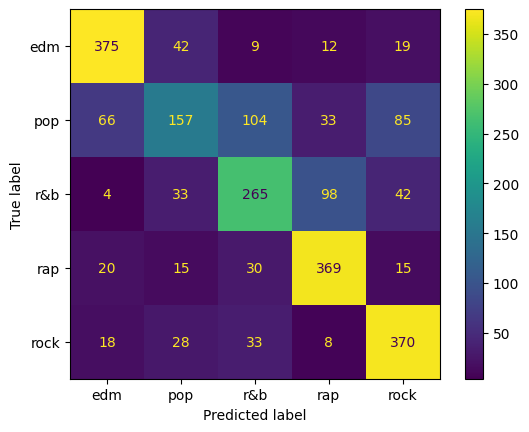

In [292]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
labels = lyric_models[0].classes_
cm = confusion_matrix(y_test, ensemble_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

### Plotting ROC Curves (One vs Rest)

In [297]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_pred = label_binarizer.transform(ensemble_pred)

(2250, 5)

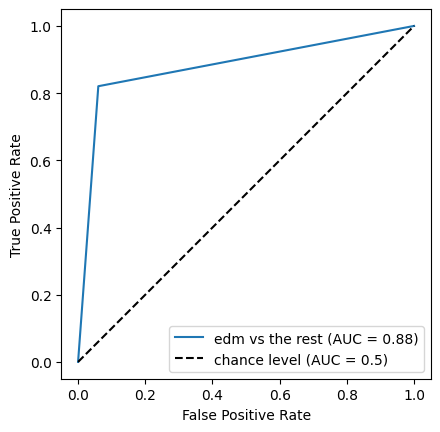

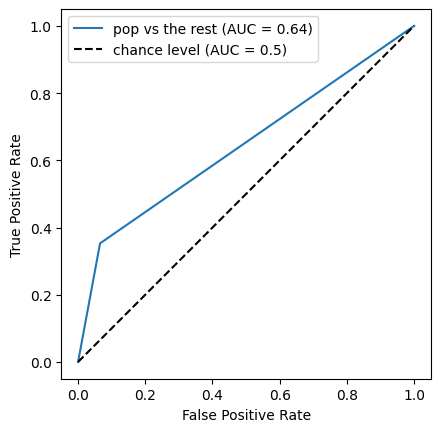

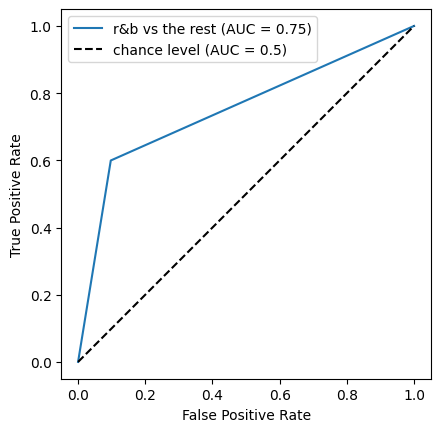

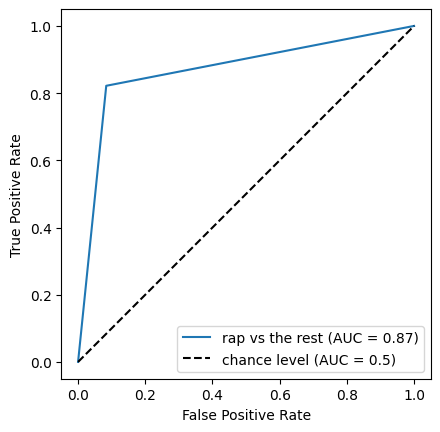

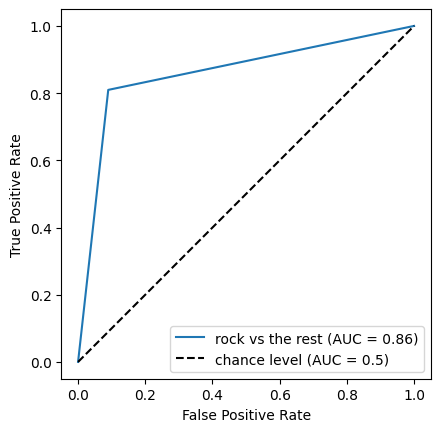

In [308]:
for label in labels:
    class_of_interest = label
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_onehot_pred[:, class_id],
        name=f"{class_of_interest} vs the rest",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print()